In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt


## Load MINST dataset

In [2]:
# Load the MNIST dataset using fetch_openml
mnist = fetch_openml('mnist_784', version=1)

# Extract the features (pixel values) and labels from the dataset
X = mnist.data.values.astype('float32')
y = mnist.target.values.astype('int64')

# Print the shape of the data arrays
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


X shape: (70000, 784)
y shape: (70000,)


In [3]:
# Subset data to use only class 0 and class 1
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

## Standarize Dataset:

In [4]:
# Define a small epsilon value to add to the standard deviation to avoid division by zero
eps = 1e-8

# Calculate the standard deviation of each feature and replace any zero values with eps
std_dev = np.std(X, axis=0)
std_dev[std_dev == 0] = eps

# Normalize the data by subtracting the mean and dividing by the standard deviation
X = (X - np.mean(X, axis=0)) / std_dev

## Implement Logistic Regression

In [6]:
class LogisticRegression:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize the weights and bias to zeros
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradient descent
        for _ in range(self.n_iters):
            # Calculate the linear model using dot product of weights and features, and add the bias
            linear_model = np.dot(X, self.weights) + self.bias
            
            # Apply sigmoid function to get the predicted probabilities
            y_predicted = self._sigmoid(linear_model)
            
            # Calculate the gradient of the cost function using the predicted probabilities and true labels
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/n_samples) * np.sum(y_predicted - y)
            
            # Update the weights and bias using the gradient and learning rate
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
    
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        return np.where(y_predicted > 0.5, 1, 0)
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def binary_cross_entropy_loss(self,y_true, y_pred):

      # Ensure inputs are numpy arrays
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)

      # Clip predictions to avoid NaNs in log calculations
      y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

      # Calculate loss
      loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)).mean()

      return loss


## K-Fold cross validation implementaion for different learning rate

In [14]:
# Define the learning rates to try
learning_rates = [0.001, 0.01, 0.1, 1]

# Define number of folds
k = 10

# Shuffle indices
np.random.seed(42)
indices = np.random.permutation(len(X))

# Split indices into k folds
fold_size = len(X) // k
folds = [indices[i*fold_size:(i+1)*fold_size] for i in range(k)]

# Initialize lists to store the validation accuracies for each learning rate
val_accs_by_lr = []


for lr in learning_rates:
  # Initialize lists to store the validation accuracies and loss
  val_accs = []
  cost_loss = []

  print(f"Training with learning rate = {lr}")

  # Perform cross-validation
  for i in range(k):
      # Split data into training and validation sets

      # the outer loop is iterating over the k folds, and for each iteration, the validation set is identified by folds[i]
      val_indices = folds[i]

      # The training set is constructed by concatenating the indices of all the folds except the i-th fold
      train_indices = np.concatenate([folds[j] for j in range(k) if j != i])
      
      X_train, y_train = X[train_indices], y[train_indices]
      X_val, y_val = X[val_indices], y[val_indices]
        
      # Initialize the model with the current learning rate
      model = LogisticRegression(lr=lr)
    
      
      # Train the model on the training data
      model.fit(X_train, y_train)
      
      # Predict the labels of the validation data
      y_pred = model.predict(X_val)

      
      # Calculate the validation accuracy and store it in the list
      acc = np.sum(y_pred == y_val)/len(y_val)
      val_accs.append(acc)

      print(f"Fold {i+1}: {acc}")

      # Test Binary cross entroby

      loss = model.binary_cross_entropy_loss(y_val,y_pred)
      cost_loss.append(loss)
      print("Binary cross entropy: ", loss)

  # Calculate the average validation accuracy for the current learning rate and store it in the list
  avg_val_acc = np.mean(val_accs)
  val_accs_by_lr.append(avg_val_acc)  
  print("Average Accuracy: ", np.mean(val_accs))
  print("Average cost: ", np.mean(cost_loss))
  print()

Training with learning rate = 0.001
Fold 1: 0.9959404600811907
Binary cross entropy:  0.14021424652003825
Fold 2: 0.9993234100135318
Binary cross entropy:  0.02336913125327629
Fold 3: 0.9979702300405954
Binary cross entropy:  0.07010739375982686
Fold 4: 0.9979702300405954
Binary cross entropy:  0.07010739375982686
Fold 5: 0.9959404600811907
Binary cross entropy:  0.14021424652003825
Fold 6: 0.9972936400541272
Binary cross entropy:  0.09347652501310214
Fold 7: 0.9959404600811907
Binary cross entropy:  0.14021424652003825
Fold 8: 0.9959404600811907
Binary cross entropy:  0.14021208252158035
Fold 9: 0.996617050067659
Binary cross entropy:  0.11684511526676296
Fold 10: 0.993234100135318
Binary cross entropy:  0.23369023053352492
Average Accuracy:  0.996617050067659
Average cost:  0.11684506116680152

Training with learning rate = 0.01
Fold 1: 0.9979702300405954
Binary cross entropy:  0.07010685276021239
Fold 2: 1.0
Binary cross entropy:  9.992007221626413e-16
Fold 3: 0.9993234100135318
Bin

## Plot the validation accuracies vs. the learning rates

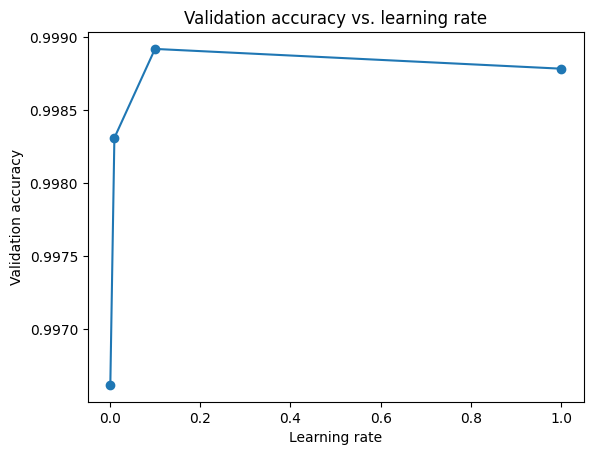

In [15]:
plt.plot(learning_rates, val_accs_by_lr, 'o-')
plt.xlabel('Learning rate')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy vs. learning rate')
plt.show()